Setup, Configuration, and Library Imports

In [ ]:
# Cell 1: Setup and Configuration

# Install necessary advanced libraries
# -q makes the installation quiet
!pip install -q lightgbm xgboost catboost shap imbalanced-learn joblib

# Import core libraries
import time, joblib, warnings, os
warnings.filterwarnings("ignore") # Suppress minor warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Import Scikit-learn and imbalanced-learn modules
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, roc_curve)
from imblearn.over_sampling import SMOTE

# Import specific ensemble models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import shap

print("✅ All required libraries loaded.")

# ========== Global Configuration Variables ==========
RND = 42           # Random Seed: Ensures results are reproducible across runs
N_ESTIMATORS = 400 # Number of boosting rounds/trees for ensemble models
OUTER_FOLDS = 5    # Number of folds for Stratified Cross-Validation (CV)
TOP_K = 30         # Initial features to consider from importance
FINAL_TOP_K = 15   # Final number of features to use in the model
np.random.seed(RND)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00
✅ All required libraries loaded.


Data Loading and Initial Inspection

In [ ]:
# Cell 2: Data Loading and Inspection

CSV_FILE = "synthetic_healthcare_data.csv"

try:
    # Load the dataset using pandas
    df = pd.read_csv(CSV_FILE)
    print(f"Dataset '{CSV_FILE}' loaded successfully.")
except FileNotFoundError:
    print(f"🛑 ERROR: File '{CSV_FILE}' not found. Please upload it to your Colab environment.")
    exit()

# Display core information for the review
print("\nDataFrame Shape:", df.shape)

# Crucial check: Show the class imbalance. The model must handle this.
print("Target distribution (proportion):")
print(df['Diagnosis'].value_counts(normalize=True).rename('proportion'))

print("\nSample Rows:")
display(df.head())
print("\nSummary Statistics:")
display(df.describe().T)

Dataset 'synthetic_healthcare_data.csv' loaded successfully.

DataFrame Shape: (49942, 16)
Target distribution (proportion):
Diagnosis
1    0.891074
0    0.108926
Name: proportion, dtype: float64

Sample Rows:


,Age,Sex,BMI,Family_History,Hypertension,Smoking_Status,Physical_Activity,Stress_Level,Steps,Sleep_Quality,Cholesterol_mg/dL,HDL_mg/dL,LDL_mg/dL,Glucose_Fasting_mg/dL,Insulin_uIU/mL,Diagnosis
0,69,Female,25.45,1,1,0,2.7,3.3,4620.0,66.4,223.3,51.2,151.6,112.1,16.3,1
1,32,Male,27.66,0,0,1,5.6,3.3,4563.0,77.4,251.2,52.8,167.3,125.1,14.6,1
2,89,Male,35.33,1,1,0,3.7,4.5,5349.0,61.6,223.9,44.7,152.3,154.5,17.2,1
3,78,Male,28.99,1,0,0,3.7,4.2,3853.0,69.7,225.9,57.6,141.1,96.8,13.9,1
4,38,Female,26.05,1,0,0,5.6,4.0,10378.0,65.7,185.8,56.0,103.6,140.9,15.7,1



Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,49942.0,53.398202,20.799213,18.00,35.00,53.00,71.00,89.00
BMI,49942.0,26.525566,4.004107,10.02,23.83,26.51,29.24,42.33
Family_History,49942.0,0.404770,0.490852,0.00,0.00,0.00,1.00,1.00
Hypertension,49942.0,0.299788,0.458169,0.00,0.00,0.00,1.00,1.00
Smoking_Status,49942.0,0.201654,0.401239,0.00,0.00,0.00,0.00,1.00
Physical_Activity,49942.0,3.000831,1.497091,-3.00,2.00,3.00,4.00,9.90
Stress_Level,49942.0,4.999441,1.985741,-4.00,3.70,5.00,6.30,13.10
Steps,49942.0,5678.888170,1811.715904,3.00,4445.00,5670.00,6903.00,13449.00
Sleep_Quality,49942.0,60.014661,11.699642,11.80,52.10,60.10,67.90,100.00
Cholesterol_mg/dL,49942.0,219.662815,30.602369,90.30,199.00,219.80,240.30,352.70


Feature Preparation and Selection

In [ ]:
# Cell 3: Feature Selection using LightGBM Importance

# Identify numerical and categorical columns
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols + ['Diagnosis']]

# Prepare data for importance estimation (temporary encoding)
X_temp = df[num_cols + cat_cols].copy()
if cat_cols:
    oe_imp = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_temp[cat_cols] = oe_imp.fit_transform(X_temp[cat_cols])
y_all = df['Diagnosis'].astype(int).values

# 1. Train a temporary LightGBM model (fast)
lgb_tmp = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=RND, n_jobs=-1)
lgb_tmp.fit(X_temp, y_all)

# 2. Extract and sort importances
imp = pd.Series(lgb_tmp.feature_importances_, index=X_temp.columns).sort_values(ascending=False)

# 3. Select final feature set (Top 15 + ensure 'Sex' is included)
top_feats = imp.head(TOP_K).index.tolist()
selected_features = list(dict.fromkeys(top_feats[:FINAL_TOP_K] + ['Sex']))
print("\nSelected features (FINAL SET):", selected_features)

[LightGBM] [Info] Number of positive: 44502, number of negative: 5440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 49942, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.891074 -> initscore=2.101755
[LightGBM] [Info] Start training from score 2.101755

Selected features (FINAL SET): ['Glucose_Fasting_mg/dL', 'Cholesterol_mg/dL', 'BMI', 'Stress_Level', 'LDL_mg/dL', 'Steps', 'Sleep_Quality', 'Physical_Activity', 'HDL_mg/dL', 'Insulin_uIU/mL', 'Age', 'Family_History', 'Hypertension', 'Sex', 'Smoking_Status']


Define Ensemble Stacking Model

In [ ]:
# Cell 4: Define Base Learners and Stacking Ensemble

# Initialize four diverse Base Models
lgbm_clf = lgb.LGBMClassifier(n_estimators=N_ESTIMATORS, learning_rate=0.03, random_state=RND, class_weight='balanced', n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=N_ESTIMATORS, learning_rate=0.03, max_depth=6, random_state=RND, use_label_encoder=False, eval_metric='auc', verbosity=0, n_jobs=-1)
cat_clf = CatBoostClassifier(iterations=N_ESTIMATORS, learning_rate=0.03, depth=6, random_seed=RND, verbose=0)
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=12, class_weight='balanced_subsample', random_state=RND, n_jobs=-1)

estimators = [
    ('lgb', lgbm_clf),
    ('xgb', xgb_clf),
    ('cat', cat_clf),
    ('rf', rf_clf)
]

# Define Meta-Learner (Logistic Regression)
meta_learner = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RND)

# Define the Stacking Classifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,                 # Internal CV for generating meta-features
    n_jobs=-1
)
print("✅ Stacking Ensemble model defined successfully.")

✅ Stacking Ensemble model defined successfully.


Stratified Cross-Validation (Training and Evaluation)

In [ ]:
# Cell 5: Stratified Cross-Validation with SMOTE

X = df[selected_features].copy()
y = df['Diagnosis'].astype(int).values

# Final encoding for selected categorical features
cat_cols_selected = [c for c in X.columns if X[c].dtype == 'object']
if cat_cols_selected:
    oe_final = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols_selected] = oe_final.fit_transform(X[cat_cols_selected])

skf = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RND)
fold_results = []
oof_preds = np.zeros(len(X))
oof_proba = np.zeros(len(X))
start_all = time.time()

fold_no = 1
for train_idx, test_idx in skf.split(X, y):
    t0 = time.time()
    print(f"\n--- Starting Fold {fold_no}/{OUTER_FOLDS} ---")
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # 1. Scaling (fit only on train data)
    scaler_local = StandardScaler()
    X_tr_scaled = scaler_local.fit_transform(X_tr)
    X_te_scaled = scaler_local.transform(X_te)

    # 2. SMOTE (Oversampling on training data only)
    sm = SMOTE(random_state=RND)
    X_res, y_res = sm.fit_resample(X_tr_scaled, y_tr)
    print(f"SMOTE applied. New training size: {X_res.shape}")

    # 3. Model Training
    stack_clf.fit(X_res, y_res)

    # 4. Prediction and Metric Calculation
    y_pred = stack_clf.predict(X_te_scaled)
    y_proba = stack_clf.predict_proba(X_te_scaled)[:, 1]

    # Store Out-Of-Fold (OOF) predictions
    oof_preds[test_idx] = y_pred
    oof_proba[test_idx] = y_proba

    # Calculate and store fold metrics
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_te, y_proba)
    elapsed = time.time() - t0

    print(f"Fold {fold_no} — Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}  (Time: {elapsed:.1f}s)")
    fold_results.append({'fold': fold_no, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': roc_auc, 'time_s': elapsed})
    fold_no += 1

print(f"\n--- CV Complete! Total time: {(time.time()-start_all)/60:.2f} minutes ---")

res_df = pd.DataFrame(fold_results)
print("\n=== Cross-validated results (per-fold) ===")
display(res_df)
print("\nMean metrics (Overall Performance):")
print(res_df[['acc','prec','rec','f1','auc']].mean().round(4))


--- Starting Fold 1/5 ---
SMOTE applied. New training size: (71202, 15)
Fold 1 — Acc: 0.9791, F1: 0.9882, AUC: 0.9567  (Time: 529.1s)

--- Starting Fold 2/5 ---
SMOTE applied. New training size: (71202, 15)
Fold 2 — Acc: 0.9760, F1: 0.9865, AUC: 0.9639  (Time: 472.5s)

--- Starting Fold 3/5 ---
SMOTE applied. New training size: (71204, 15)
Fold 3 — Acc: 0.9720, F1: 0.9842, AUC: 0.9622  (Time: 466.5s)

--- Starting Fold 4/5 ---
SMOTE applied. New training size: (71204, 15)
Fold 4 — Acc: 0.9755, F1: 0.9862, AUC: 0.9529  (Time: 471.8s)

--- Starting Fold 5/5 ---
SMOTE applied. New training size: (71204, 15)
Fold 5 — Acc: 0.9742, F1: 0.9855, AUC: 0.9561  (Time: 475.8s)

--- CV Complete! Total time: 40.26 minutes ---

=== Cross-validated results (per-fold) ===


,fold,acc,prec,rec,f1,auc,time_s
0,1,0.979077,0.989525,0.986968,0.988245,0.956713,529.067507
1,2,0.975974,0.990597,0.982362,0.986462,0.963857,472.524252
2,3,0.971966,0.988441,0.980000,0.984202,0.962218,466.527948
3,4,0.975471,0.987057,0.985393,0.986224,0.952884,471.799537
4,5,0.974169,0.988028,0.982921,0.985468,0.956080,475.757771



Mean metrics (Overall Performance):
acc     0.9753
prec    0.9887
rec     0.9835
f1      0.9861
auc     0.9584
dtype: float64


Threshold Tuning and Final Evaluation

In [ ]:
# Cell 6: Threshold Tuning and Final OOF Report

# 1. Search for the best threshold (0.3 to 0.7) to maximize F1 score
best_thr = 0.5
best_f1 = f1_score(y, (oof_proba >= best_thr).astype(int))

for thr in np.linspace(0.3, 0.7, 41):
    f1_thr = f1_score(y, (oof_proba >= thr).astype(int))
    if f1_thr > best_f1:
        best_f1 = f1_thr
        best_thr = thr

print(f"Optimal OOF threshold (F1 max): {best_thr:.3f} with OOF F1 = {best_f1:.4f}")

# 2. Apply the optimal threshold to get final OOF predictions
oof_pred_thr = (oof_proba >= best_thr).astype(int)

# 3. Print the final classification report and ROC-AUC
print("\n=== OOF Classification Report (Threshold Tuned) ===")
print(classification_report(y, oof_pred_thr, digits=4))
print("OOF ROC-AUC:", roc_auc_score(y, oof_proba).round(4))

Optimal OOF threshold (F1 max): 0.310 with OOF F1 = 0.9874

=== OOF Classification Report (Threshold Tuned) ===
              precision    recall  f1-score   support

           0     0.8922    0.9035    0.8978      5440
           1     0.9882    0.9867    0.9874     44502

    accuracy                         0.9776     49942
   macro avg     0.9402    0.9451    0.9426     49942
weighted avg     0.9777    0.9776    0.9777     49942

OOF ROC-AUC: 0.9582


Final Model Training and Saving Artifacts

In [ ]:
# Cell 7: Final Model Training and Saving

print("Training final model on full resampled dataset...")

# 1. Scale all data
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)

# 2. SMOTE on all data
sm_full = SMOTE(random_state=RND)
X_res_full, y_res_full = sm_full.fit_resample(X_scaled_full, y)

# 3. Train final Stacking Model
stack_clf.fit(X_res_full, y_res_full)

# 4. Save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(stack_clf, "artifacts/stacking_model.joblib")
joblib.dump(scaler_full, "artifacts/scaler_full.joblib")
joblib.dump(selected_features, "artifacts/selected_features.pkl")

print("\n✅ Saved final model, scaler, and features to ./artifacts/")

Training final model on full resampled dataset...

✅ Saved final model, scaler, and features to ./artifacts/


Visualizations and Model Explainability (SHAP)


--- Generating Visualizations ---


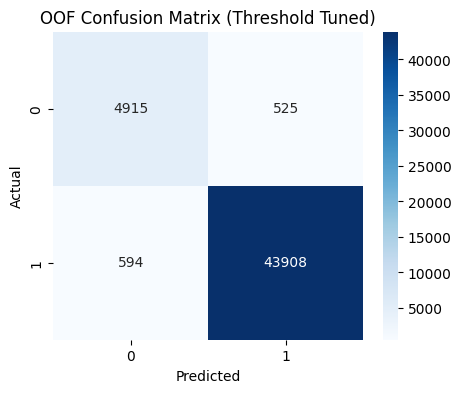

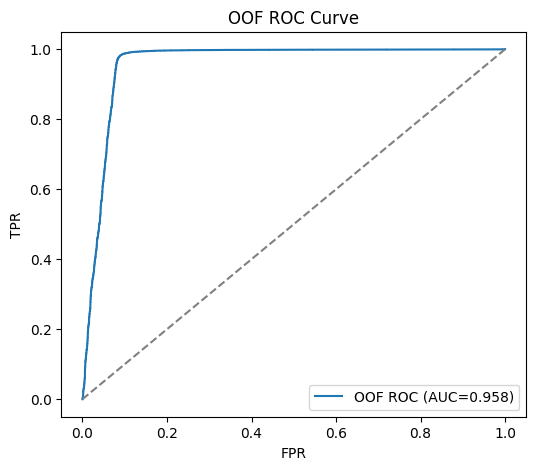

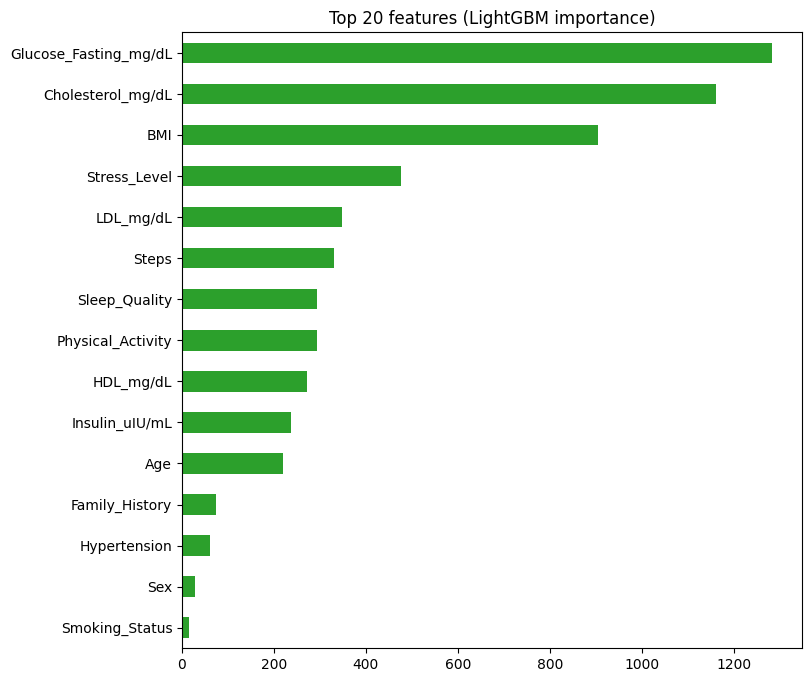


Plotting SHAP summary (Bar Plot: Global Feature Impact)...


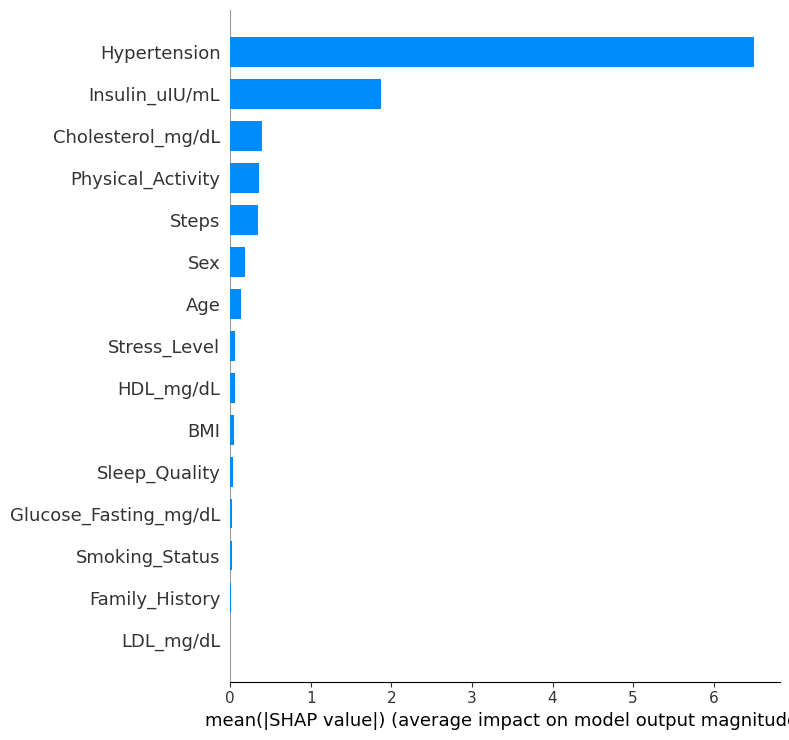


=== FINAL SUMMARY FOR PROJECT REVIEW ===
Mean CV Metrics:
 acc     0.9753
prec    0.9887
rec     0.9835
f1      0.9861
auc     0.9584
dtype: float64

OOF F1 (Threshold Tuned): 0.9874
OOF ROC-AUC: 0.9582


In [ ]:
# Cell 8: Visualizations and Explainability

print("\n--- Generating Visualizations ---")

# 1. Confusion Matrix (OOF - Threshold Tuned)
cm = confusion_matrix(y, oof_pred_thr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("OOF Confusion Matrix (Threshold Tuned)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# 2. ROC Curve (OOF)
fpr, tpr, _ = roc_curve(y, oof_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"OOF ROC (AUC={roc_auc_score(y, oof_proba):.3f})")
plt.plot([0,1],[0,1],'--', color='gray'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("OOF ROC Curve"); plt.legend()
plt.show()

# 3. Feature Importance (from initial LGB model)
top_imp = imp.head(20)
plt.figure(figsize=(8,8)); top_imp.sort_values().plot.barh(color='tab:green'); plt.title("Top 20 features (LightGBM importance)"); plt.show()

# 4. SHAP (Model Explainability)
# SHAP explains the output of the model for a sample of data
try:
    # Use the simple LGB model for quick SHAP calculation
    explainer = shap.TreeExplainer(lgb_tmp)
    sample_X = X_temp[top_feats].sample(1000, random_state=RND) # Use 1000 samples for speed
    shap_values = explainer.shap_values(sample_X)

    print("\nPlotting SHAP summary (Bar Plot: Global Feature Impact)...")
    # The SHAP bar plot shows the average magnitude of impact for each feature
    shap.summary_plot(shap_values, sample_X, plot_type="bar", show=True)

except Exception as e:
    print(f"SHAP plot skipped due to an error: {e}")

# Final print summary
print("\n=== FINAL SUMMARY FOR PROJECT REVIEW ===")
print("Mean CV Metrics:\n", res_df[['acc','prec','rec','f1','auc']].mean().round(4))
print("\nOOF F1 (Threshold Tuned):", round(best_f1, 4))
print("OOF ROC-AUC:", roc_auc_score(y, oof_proba).round(4))